In [64]:
!pip install contractions
!pip install pyLDAvis
!pip install matplotlib
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [131]:
import pandas as pd

df = pd.read_json('all_posts_TillSverige.json', 'values')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932 entries, 0 to 931
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       932 non-null    object
dtypes: object(1)
memory usage: 7.4+ KB


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-131-91f5d91f3051>:3: FutureWarning: Starting with pandas version 2.0 all arguments of read_json except for the argument 'path_or_buf' will be keyword-only.
  df = pd.read_json('all_posts_TillSverige.json', 'values')


In [132]:
df.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0
0,A fence for a dog Hi! I would like to fence a ...
1,"Moving to Sweden from Georgia Hej, everyone!\..."
2,Can you register for a personnummer… in a city...
3,What stores would sell bathrobes for men? I kn...
4,SL card or ticket on your phone Can someone he...


## Text pre-processing


In [142]:
import nltk
import re
import numpy as np
import contractions
from nltk.stem import PorterStemmer

lematizer = nltk.stem.WordNetLemmatizer()
ps = PorterStemmer()

stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words.add("n't")

def normalize_posts(posts, token_normalizator):
  normal_word_pattern = re.compile('[a-zäöå]')
  tokens = []
  for post in posts:
      norm_post_tokens = []
      post_lower_case = post.lower()
      post_tokens = nltk.word_tokenize(post)
      for token in post_tokens:
        if normal_word_pattern.match(token) and token not in stop_words:
          norm_post_tokens.append(token_normalizator(token))
      tokens.append(norm_post_tokens.copy())    
  return tokens    

texts = list(df[0].transpose())

norm_corpus_stem = normalize_posts(texts, ps.stem)
norm_corpus_lem = normalize_posts(texts, lematizer.lemmatize)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Topics Modeling


In [186]:
from gensim.models import CoherenceModel

def getCoherenceScore(model, texts, dictionary):
  coh_model_bw = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence = 'c_v')
  return coh_model_bw.get_coherence()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [195]:
from gensim import corpora
from gensim import models

def getTopicModels(texts, min_topic_num=2, max_topics_num=10, random_state=7):
  dictionary = corpora.Dictionary(texts)
  corpus = [dictionary.doc2bow(text) for text in texts]
  tfidf_model = models.TfidfModel(corpus)  
  tfidf = tfidf_model[corpus]
  ldaModels = []
  ldaMultModels = []
  lsiModels = []
  ldaCohScores = []
  ldaMultCohScores = []
  lsiCohScores = []
  topics = list(range(min_topic_num, max_topics_num))
  iterations = 100
  passes = 20
  
  for topicsNum in topics:
    ldaModels.append(models.LdaModel(tfidf, id2word=dictionary, num_topics=topicsNum, random_state=random_state, iterations=iterations, passes=passes))
    ldaMultModels.append(models.LdaMulticore(tfidf, num_topics=topicsNum, random_state=random_state, id2word=dictionary, iterations=iterations, passes=passes))
    lsiModels.append(models.LsiModel(tfidf, id2word=dictionary, num_topics=topicsNum, random_seed=random_state ))
    ldaCohScores.append(getCoherenceScore(ldaModels[topicsNum - 2], texts, dictionary))
    ldaMultCohScores.append(getCoherenceScore(ldaMultModels[topicsNum - 2], texts, dictionary))
    lsiCohScores.append(getCoherenceScore(lsiModels[topicsNum - 2], texts, dictionary))

  return [[ldaModels, ldaCohScores],
          [ldaMultModels, ldaMultCohScores],
          [lsiModels, lsiCohScores], corpus]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [180]:
import matplotlib.pyplot as plt

def plot(x_values, y_values, labels, x_axis_label, y_axis_label, marker='o'):
  i = 0
  for y in y_values:
    plt.plot(x_values, y, label = labels[i], marker='o')
    i = i + 1
  plt.xlabel(x_axis_label, fontsize=14)
  plt.ylabel(y_axis_label, fontsize=14)
  plt.grid(True)
  plt.legend()
  plt.show()  

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [196]:
MIN_TOPIC_NUMBER = 2
MAX_TOPIC_NUMBER = 7
stem_models = getTopicModels(norm_corpus_stem, min_topic_num=MIN_TOPIC_NUMBER, max_topics_num=MAX_TOPIC_NUMBER)
lem_models = getTopicModels(norm_corpus_lem, min_topic_num=MIN_TOPIC_NUMBER, max_topics_num=MAX_TOPIC_NUMBER)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(
/usr/local/lib/python3.9/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(
/usr/local/lib/python3.9/dist-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools`

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


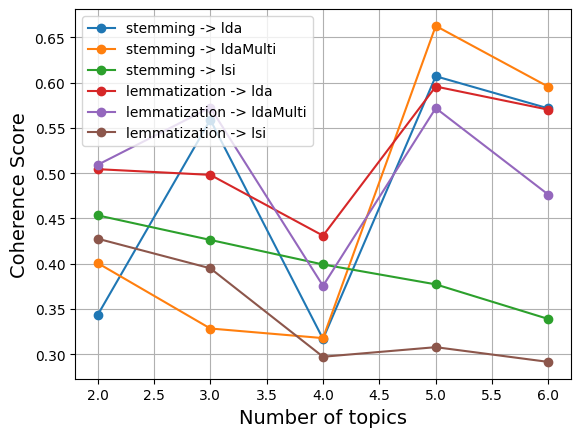

In [198]:
topics = list(range(MIN_TOPIC_NUMBER, MAX_TOPIC_NUMBER))
modelsCohScores = [stem_models[0][1], stem_models[1][1], stem_models[2][1], lem_models[0][1], lem_models[1][1], lem_models[2][1] ]
labels = ['stemming -> lda', 'stemming -> ldaMulti', 'stemming -> lsi', 'lemmatization -> lda', 'lemmatization -> ldaMulti', 'lemmatization -> lsi']
plot(topics, modelsCohScores, labels, 'Number of topics', 'Coherence Score')

In [208]:
bestModel = stem_models[1][0][3]
corpus = stem_models[3]
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(bestModel, corpus, dictionary=bestModel.id2word)
vis

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.140414 -0.000509       1        1  94.651878
2     -0.031363  0.015819       2        1   1.438150
3     -0.037559 -0.009381       3        1   1.364949
1     -0.036641 -0.004844       4        1   1.322997
0     -0.034850 -0.001084       5        1   1.222027, topic_info=          Term        Freq       Total Category  logprob  loglift
141        buy   86.000000   86.000000  Default  30.0000  30.0000
592      apart  120.000000  120.000000  Default  29.0000  29.0000
112       citi   46.000000   46.000000  Default  28.0000  28.0000
739     servic   48.000000   48.000000  Default  27.0000  27.0000
489   interest   44.000000   44.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
621        eye    0.509712    7.802644   Topic5  -7.0451   1.6763
1661     night    0.571617   15.450181   Topic5  -6.9304   1.1078
1440   definit    0.462598   10.829700   Topic5  -7.1420   1.2515
694        wan    0.445560   16.608300   Topic5  -7.1796   0.7863
126   birthday    0.438686    7.138486   Topic5  -7.1951   1.6152

[242 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
296       1  0.994237   account
1885      1  0.706661        af
2088      1  0.765411     amort
124       1  0.993616       amp
24        1  0.995684     anyon
...     ...       ...       ...
856       1  0.743841  work-lif
16        1  0.996893     would
111       1  0.997101      year
1092      1  0.912804     young
1092      2  0.091280     young

[332 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 2, 1])